<h1 style="background-color:rgb(67, 194, 50); text-align: center"> PredFinAI – Corporate Bankruptcy Prediction Using Machine Learning Models</h1>

**Objective**
This project aims to build a clean and analyzable dataset of corporate financial metrics sourced from the SEC EDGAR database. This data will later serve as the foundation for predictive models capable of estimating the probability of bankruptcy, financial distress, or credit defaults. In this phase, we focus on ETL (Extract, Transform, Load) processes and EDA (Exploratory Data Analysis).

**Data Source**
We use publicly available data from the SEC EDGAR portal, specifically the Financial Statement and Notes Datasets: https://www.sec.gov/data-research/sec-markets-data/financial-statement-notes-data-sets.

These datasets include structured financial statements and explanatory notes submitted by publicly traded U.S. companies, typically as part of annual reports (10-K forms). The data is extracted directly from XBRL filings and organized into machine-readable tables.

🔹 Documentation of file structure, scope, and field definitions is provided in the official technical specification: https://www.sec.gov/files/dera/data/financial-statement-notes-data-sets/2025_02_notes.zip

These resources contain:

Company identifiers (CIK, form type, filing date)

Detailed financial metrics, including:

Assets and liabilities

Revenue, income, and earnings per share

Cash flow statements

Liquidity, solvency, and profitability ratios

Footnotes and textual metadata that may indicate risk, uncertainty, or early signals of financial distress

The data is structured across several normalized tables such as sub.txt, num.txt, tag.txt, etc., which can be joined using common keys.

This comprehensive dataset serves as the foundation for our ETL pipeline, feature engineering, and eventual machine learning model for bankruptcy prediction.

In [373]:
# %conda init
# %conda deactivate
# %conda activate credit-analysis-dashboard
# %conda install numpy pandas requests bs4 tqdm openai matplotlib seaborn 
# %conda install -c conda-forge ratelimit lxml statsmodels 
# %conda install conda-forge::nltk

In [374]:
import numpy as np # linear algebra, arithmentic calculations
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [375]:
!pip install scikit-learn


<h2 style="background-color: #ffd5cd; text-align: center">ELT-Extract</h2>

In [505]:
import requests
from zipfile import ZipFile, BadZipFile
from datetime import datetime

# Base URL for the reports
base_url = "https://www.sec.gov/files/dera/data/financial-statement-notes-data-sets/{}_02_notes.zip"

# Local directory to save the files
local_dir = "C:/Users/natal/credit-analysis-dashboard-v1/data/raw/"

# Current year
current_year = datetime.now().year

# Iterate over the last 10 years
for year in range(current_year - 10, current_year):
    url = base_url.format(year)
    local_filename = f"{local_dir}{year}_02_notes.zip"

    # Download the file
    headers = {
        "User-Agent": "NataliaStekolnikova-FinRiskApp/1.0 (natalia.a.stekolnikova@gmail.com)",
        "Accept-Encoding": "gzip, deflate",
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8",
        "Connection": "keep-alive",
        "Host": "www.sec.gov",  # Add the Host header
        "Referer": "https://www.sec.gov/",  # Add a Referer header
        "From": "natalia.a.stekolnikova@gmail.com"  # Replace with your email address
    }
    response = requests.get(url, headers=headers, stream=True)
    if response.status_code == 200:
        with open(local_filename, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print(f"Downloaded: {local_filename}")

        # Extract the zip
        try:
            with ZipFile(local_filename, 'r') as zip_ref:
                extract_path = f"{local_dir}{year}_02_notes/"
                zip_ref.extractall(extract_path)
                print(f"Extracted to {extract_path}")
        except BadZipFile:
            print(f"Error: The downloaded file for {year} is not a valid ZIP file.")
    else:
        print(f"Failed to download file for {year}. Status code: {response.status_code}")

Failed to download file for 2015. Status code: 404
Failed to download file for 2016. Status code: 404
Failed to download file for 2017. Status code: 404
Failed to download file for 2018. Status code: 404
Failed to download file for 2019. Status code: 404
Failed to download file for 2020. Status code: 404
Downloaded: C:/Users/natal/credit-analysis-dashboard-v1/data/raw/2021_02_notes.zip
Extracted to C:/Users/natal/credit-analysis-dashboard-v1/data/raw/2021_02_notes/
Downloaded: C:/Users/natal/credit-analysis-dashboard-v1/data/raw/2022_02_notes.zip
Extracted to C:/Users/natal/credit-analysis-dashboard-v1/data/raw/2022_02_notes/
Failed to download file for 2023. Status code: 404
Downloaded: C:/Users/natal/credit-analysis-dashboard-v1/data/raw/2024_02_notes.zip
Extracted to C:/Users/natal/credit-analysis-dashboard-v1/data/raw/2024_02_notes/


<h2 style="background-color: #ffd5cd; text-align: center">ELT-Load</h2>

### Overview: SEC Financial Statement Data — File Utility for Predictive Modeling

| File        | Description                                                                                      | Use for Modeling                                                               |
|-------------|--------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------|
| `num.tsv`   | Contains actual **financial values** (e.g., revenue, net income, assets, liabilities).           | **Core dataset** for training features and targets.                           |
| `sub.tsv`   | Metadata: company ID (CIK), name, SIC, reporting period, form type (10-K, 10-Q), etc.            | Used to **filter and contextualize** `num.tsv` data.                          |
| `tag.tsv`   | Dictionary of all tags: names, labels, definitions, and whether standard or custom.              | Helps map tags to consistent financial concepts (e.g., revenue, income, etc). |
| `dim.tsv`   | Dimension info (e.g., data by business segments, geographic regions).                            | Used to **filter for consolidated data** or include segment-level details.    |
| `pre.tsv`   | Shows how line items appear in statements (e.g., order, section, label).                         | Useful for **resolving ambiguous/custom tags**.                               |
| `cal.tsv`   | Arithmetic relationships (e.g., which tags sum to totals).                                        | Optional: **reconstruct or validate missing/aggregated values**.              |
| `ren.tsv`   | Report rendering structure for display in SEC viewer.                                            | Not relevant for prediction modeling.                                       |
| `txt.tsv`   | Text blocks (e.g., accounting policies, risk notes, disclosures).                                 | Only useful for **NLP-based analysis**, not for numeric modeling.          |


In [508]:
# Define the years of interest
years_of_interest = [2021, 2022, 2024, 2025]

# Initialize a dictionary to store DataFrames for each year
dataframes_by_year = {}

# Iterate over the years of interest
for year in years_of_interest:
    # Define the input directory for the current year
    year_input_dir = DATA_INPUT_DIR.format(year)
    
    # Check if the directory exists
    if os.path.exists(year_input_dir):
        # List of file names to load
        file_names = ["sub", "num", "tag", "cal", "dim", "pre", "ren", "txt"]
        
        # Load each .tsv file into a DataFrame and store it in the dictionary
        dataframes_by_year[year] = {
            file_name: pd.read_csv(os.path.join(year_input_dir, f"{file_name}.tsv"), sep='\t', low_memory=False)
            for file_name in file_names
        }
        print(f"Data for year {year} loaded successfully!")
    else:
        print(f"Directory for year {year} does not exist.")

# Concatenate data for each file type across all years
file_types = ["sub", "num", "tag", "cal", "dim", "pre", "ren", "txt"]
globals().update({
    file_type: pd.concat(
        [dataframes_by_year[year][file_type] for year in years_of_interest if file_type in dataframes_by_year[year]],
        ignore_index=True
    )
    for file_type in file_types
})


Data for year 2021 loaded successfully!
Data for year 2022 loaded successfully!
Data for year 2024 loaded successfully!
Data for year 2025 loaded successfully!


<h2 style="background-color: #ffd5cd; text-align: center">Exploratory Data Analysis (EDA)</h2>

In [512]:
sub.tail(5).transpose()

,35447,35448,35449,35450,35451
adsh,0002003881-25-000010,0002015845-25-000012,0002021938-25-000009,0002026448-25-000015,0002040266-25-000007
cik,2003881,2015845,2021938,2026448,1841666
name,"STIRLING HOTELS & RESORTS, INC.","EVERUS CONSTRUCTION GROUP, INC.",SUNRISE COMMUNICATIONS AG,PRINCIPAL CREDIT REAL ESTATE INCOME TRUST,APA CORP
sic,6798.0,1531.0,4841.0,6798.0,1311.0
countryba,US,US,CH,US,US
stprba,TX,ND,NaN,IA,TX
cityba,DALLAS,BISMARCK,"OPFIKON, ZURICH",DES MOINES,HOUSTON
zipba,75254,58503,8152,50392,77042
bas1,14185 DALLAS PARKWAY,1730 BURNT BOAT DRIVE,THURGAUERSTRASSE 101B,711 HIGH STREET,2000 W SAM HOUSTON PKWY S
bas2,SUITE 1200,NaN,GLATTPARK,NaN,SUITE 200


In [513]:
sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35452 entries, 0 to 35451
Data columns (total 40 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   adsh         35452 non-null  object 
 1   cik          35452 non-null  int64  
 2   name         35452 non-null  object 
 3   sic          34044 non-null  float64
 4   countryba    35388 non-null  object 
 5   stprba       33568 non-null  object 
 6   cityba       35384 non-null  object 
 7   zipba        35376 non-null  object 
 8   bas1         35388 non-null  object 
 9   bas2         14924 non-null  object 
 10  baph         35432 non-null  object 
 11  countryma    35380 non-null  object 
 12  stprma       33628 non-null  object 
 13  cityma       35376 non-null  object 
 14  zipma        35360 non-null  object 
 15  mas1         35364 non-null  object 
 16  mas2         14864 non-null  object 
 17  countryinc   31992 non-null  object 
 18  stprinc      29852 non-null  object 
 19  ein 

In [514]:
sub.describe()

,cik,sic,ein,changed,wksi,fye,period,fy,filed,prevrpt,detail,nciks,pubfloatusd,floatdate,floatmems
count,3.545200e+04,34044.000000,3.545200e+04,2.125600e+04,35452.000000,35280.000000,3.510000e+04,11016.000000,3.545200e+04,35452.000000,35452.000000,35452.000000,7.876000e+03,7.876000e+03,7876.000000
mean,1.272957e+06,4868.293033,4.484226e+08,2.007402e+07,0.168340,1117.708617,2.024705e+07,2024.189542,2.025022e+07,0.001015,0.322239,1.032607,1.423564e+13,2.024047e+07,1.028949
std,5.512187e+05,1983.890800,3.326467e+08,1.204460e+05,0.374173,257.735998,4.893932e+03,0.438318,8.194840e+00,0.031851,0.467340,0.281755,4.005922e+14,1.620855e+03,0.387323
min,1.800000e+03,100.000000,0.000000e+00,1.960020e+07,0.000000,120.000000,2.005123e+07,2018.000000,2.025020e+07,0.000000,0.000000,1.000000,0.000000e+00,2.020063e+07,1.000000
25%,9.218250e+05,3011.000000,1.605476e+08,1.998083e+07,0.000000,1231.000000,2.024123e+07,2024.000000,2.025021e+07,0.000000,0.000000,1.000000,6.866000e+08,2.024063e+07,1.000000
50%,1.408710e+06,4911.000000,4.118836e+08,2.010061e+07,0.000000,1231.000000,2.025013e+07,2024.000000,2.025022e+07,0.000000,0.000000,1.000000,2.300000e+09,2.024063e+07,1.000000
75%,1.710340e+06,6770.000000,8.137095e+08,2.018013e+07,0.000000,1231.000000,2.025023e+07,2024.000000,2.025022e+07,0.000000,1.000000,1.000000,8.200000e+09,2.024063e+07,1.000000
max,2.052961e+06,8900.000000,1.000000e+09,2.024122e+07,1.000000,1231.000000,2.025043e+07,2025.000000,2.025023e+07,1.000000,1.000000,8.000000,1.612464e+16,2.025013e+07,16.000000


In [515]:
num.head(5).transpose()

,0,1,2,3,4
adsh,0000002488-25-000012,0000002488-25-000012,0000002488-25-000012,0000002488-25-000012,0000002488-25-000012
tag,AccountsPayableCurrent,AccountsPayableCurrent,AccountsPayableCurrentAndNoncurrent,AccountsPayableCurrentAndNoncurrent,AccountsPayableOtherCurrentAndNoncurrent
version,us-gaap/2024,us-gaap/2024,us-gaap/2024,us-gaap/2024,us-gaap/2024
ddate,20231231,20241231,20231231,20241231,20231231
qtrs,0,0,0,0,0
uom,USD,USD,USD,USD,USD
dimh,0x00000000,0x00000000,0xad66b56c81571b0e9d4882f564c06174,0xad66b56c81571b0e9d4882f564c06174,0x00000000
iprx,0,0,0,0,0
value,2055000000.0,1990000000.0,363000000.0,476000000.0,363000000.0
footnote,NaN,NaN,NaN,NaN,NaN


In [516]:
num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20274872 entries, 0 to 20274871
Data columns (total 16 columns):
 #   Column    Dtype  
---  ------    -----  
 0   adsh      object 
 1   tag       object 
 2   version   object 
 3   ddate     int64  
 4   qtrs      int64  
 5   uom       object 
 6   dimh      object 
 7   iprx      int64  
 8   value     float64
 9   footnote  object 
 10  footlen   int64  
 11  dimn      int64  
 12  coreg     object 
 13  durp      float64
 14  datp      float64
 15  dcml      int64  
dtypes: float64(3), int64(6), object(7)
memory usage: 2.4+ GB


In [517]:
num.describe()

,ddate,qtrs,iprx,value,footlen,dimn,durp,datp,dcml
count,2.027487e+07,2.027487e+07,2.027487e+07,2.001417e+07,2.027487e+07,2.027487e+07,2.027487e+07,2.027487e+07,2.027487e+07
mean,2.023428e+07,1.703154e+00,1.115010e-01,3.234493e+10,6.169426e-01,1.025176e+00,1.745428e-03,6.217154e-02,1.706087e+03
std,9.295193e+03,2.007115e+00,5.468251e-01,4.540973e+13,2.831589e+01,1.037582e+00,2.676112e-02,1.499532e+00,8.983556e+03
min,1.870123e+07,0.000000e+00,0.000000e+00,-2.412180e+13,0.000000e+00,0.000000e+00,-4.986300e-01,-1.500000e+01,-3.276800e+04
25%,2.023123e+07,0.000000e+00,0.000000e+00,1.310000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-6.000000e+00
50%,2.024013e+07,0.000000e+00,0.000000e+00,4.097000e+06,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,-3.000000e+00
75%,2.024123e+07,4.000000e+00,0.000000e+00,1.003970e+08,0.000000e+00,2.000000e+00,1.095891e-02,0.000000e+00,-3.000000e+00
max,2.074123e+07,1.360000e+02,5.900000e+01,1.000000e+17,2.679900e+04,9.000000e+00,4.986310e-01,1.500000e+01,3.276700e+04


In [518]:
tag.head(2)

,tag,version,custom,abstract,datatype,iord,crdr,tlabel,doc
0,A.5000EuroDenominatedNotesDue2033Member,0000059478-25-000067,1,1,member,NaN,NaN,.5000% Euro Denominated Notes Due 2033 [Member],.5000% Euro Denominated Notes Due 2033
1,A.C.SolucoesParaPiscinasLda.Member,0000945841-25-000032,1,1,member,NaN,NaN,"A.C. Solucoes para Piscinas, Lda. [Member]","A.C. Solucoes para Piscinas, Lda."


In [519]:
tag.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2056052 entries, 0 to 2056051
Data columns (total 9 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   tag       object
 1   version   object
 2   custom    int64 
 3   abstract  int64 
 4   datatype  object
 5   iord      object
 6   crdr      object
 7   tlabel    object
 8   doc       object
dtypes: int64(2), object(7)
memory usage: 141.2+ MB


In [520]:
tag.describe()

,custom,abstract
count,2.056052e+06,2.056052e+06
mean,9.570731e-01,4.599942e-01
std,2.026924e-01,4.983971e-01
min,0.000000e+00,0.000000e+00
25%,1.000000e+00,0.000000e+00
50%,1.000000e+00,0.000000e+00
75%,1.000000e+00,1.000000e+00
max,1.000000e+00,1.000000e+00


In [521]:
# the tag dataset is NOT useful for our analysis

In [522]:
cal.head(2)

,adsh,grp,arc,negative,ptag,pversion,ctag,cversion
0,0001504461-25-000004,12,5,1,AccruedLiabilitiesCurrent,us-gaap/2023,TaxesPayableCurrent,us-gaap/2023
1,0000769520-25-000009,3,1,1,AccruedLiabilitiesCurrent,us-gaap/2023,ContractWithCustomerLiabilityCurrent,us-gaap/2023


In [523]:
cal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1908116 entries, 0 to 1908115
Data columns (total 8 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   adsh      object
 1   grp       int64 
 2   arc       int64 
 3   negative  int64 
 4   ptag      object
 5   pversion  object
 6   ctag      object
 7   cversion  object
dtypes: int64(3), object(5)
memory usage: 116.5+ MB


In [524]:
cal.describe()

,grp,arc,negative
count,1.908116e+06,1.908116e+06,1.908116e+06
mean,1.029212e+01,1.033055e+01,6.137006e-01
std,8.055466e+00,9.858506e+00,7.895390e-01
min,1.000000e+00,1.000000e+00,-1.000000e+00
25%,4.000000e+00,3.000000e+00,1.000000e+00
50%,8.000000e+00,7.000000e+00,1.000000e+00
75%,1.500000e+01,1.500000e+01,1.000000e+00
max,6.600000e+01,1.210000e+02,1.000000e+00


In [525]:
# the cal dataset could be useful if we need a mapping between previous tag and current tag
# but we don't need it for now

In [526]:
dim.head(5)

,dimhash,segments,segt
0,0x0942d94b9d9266bf273a2c5123d68019,BalanceSheetLocation=OtherAccruedLiabilities;D...,0
1,0xf48392632836a4db259a7d67c3a4f808,RangesOfExercisePricesForOutstandingShareOptio...,0
2,0x09d3f28b05928a485eb5ca0cf40bc7d0,BusinessSegments=LargeAccountSegment;ProductOr...,0
3,0xb0703db550a95f6c213269cbf1bed75e,MajorPropertyClassUsefulLife=Furnitureequipmen...,0
4,0x89eebd7929107c732859066c1c17c60e,DebtInstrument=SeniorUnsecuredNotesDueMay2023;,0


In [527]:
dim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1671336 entries, 0 to 1671335
Data columns (total 3 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   dimhash   1671336 non-null  object
 1   segments  1671332 non-null  object
 2   segt      1671336 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 38.3+ MB


In [528]:
dim.describe()

,segt
count,1671336.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [529]:
# the dim dataset is NOT useful for our analysis

In [530]:
pre.head(2)

,adsh,report,line,stmt,inpth,tag,version,prole,plabel,negating
0,0001104659-25-008644,1,2,NaN,0,AmendmentFlag,dei/2023,label,Amendment Flag,0
1,0000826154-25-000036,1,23,NaN,0,AmendmentFlag,dei/2023,terseLabel,Amendment Flag,0


In [531]:
pre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12874996 entries, 0 to 12874995
Data columns (total 10 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   adsh      object
 1   report    int64 
 2   line      int64 
 3   stmt      object
 4   inpth     int64 
 5   tag       object
 6   version   object
 7   prole     object
 8   plabel    object
 9   negating  int64 
dtypes: int64(4), object(6)
memory usage: 982.3+ MB


In [532]:
# the pre dataset is NOT useful for our analysis

In [533]:
ren.head(2)

,adsh,report,rfile,menucat,shortname,longname,roleuri,parentroleuri,parentreport,ultparentrpt
0,0001628280-25-003396,1,H,C,Cover,0000001 - Document - Cover,http://daveandbusters.com/role/Cover,NaN,NaN,NaN
1,0001493152-25-004617,1,H,C,Cover,00000001 - Document - Cover,http://fr8technologies.com/role/Cover,NaN,NaN,NaN


In [534]:
ren.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1077588 entries, 0 to 1077587
Data columns (total 10 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   adsh           1077588 non-null  object 
 1   report         1077588 non-null  int64  
 2   rfile          1077588 non-null  object 
 3   menucat        1077588 non-null  object 
 4   shortname      1077548 non-null  object 
 5   longname       1077588 non-null  object 
 6   roleuri        1077588 non-null  object 
 7   parentroleuri  295148 non-null   object 
 8   parentreport   295148 non-null   float64
 9   ultparentrpt   533784 non-null   float64
dtypes: float64(2), int64(1), object(7)
memory usage: 82.2+ MB


In [535]:
# the ren dataset is NOT useful for our analysis

In [536]:
txt.tail(3)

,adsh,tag,version,ddate,qtrs,iprx,lang,dcml,durp,datp,dimh,dimn,coreg,escaped,srclen,txtlen,footnote,footlen,context,value
2748261,0000950170-25-027735,CostOfSalesPolicyTextBlock,us-gaap/2024,20241231,4,0,en-US,32767,0.00000,0.0,0x00000000,0,NaN,1,1314,863,NaN,0,C_d00eba5b-9e9b-4cb5-ad83-340d13e32914,Cost of Goods Sold Cost of goods sold include...
2748262,0000950170-25-026068,Rule10b51ArrAdoptedFlag,ecd/2024,20241231,1,0,en-US,32767,0.00274,0.0,0x00000000,0,NaN,0,5,5,NaN,0,C_73e6f1f4-c5e6-4a18-a838-d18e18736139,false
2748263,0001932393-25-000005,DocumentFinStmtErrorCorrectionFlag,dei/2024,20241231,4,0,en-US,32767,0.00000,0.0,0x00000000,0,NaN,0,5,5,NaN,0,c-1,false


In [537]:
txt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2748264 entries, 0 to 2748263
Data columns (total 20 columns):
 #   Column    Dtype  
---  ------    -----  
 0   adsh      object 
 1   tag       object 
 2   version   object 
 3   ddate     int64  
 4   qtrs      int64  
 5   iprx      int64  
 6   lang      object 
 7   dcml      int64  
 8   durp      float64
 9   datp      float64
 10  dimh      object 
 11  dimn      int64  
 12  coreg     object 
 13  escaped   int64  
 14  srclen    int64  
 15  txtlen    int64  
 16  footnote  object 
 17  footlen   int64  
 18  context   object 
 19  value     object 
dtypes: float64(2), int64(9), object(9)
memory usage: 419.4+ MB


txt dataset can be useful for our analysis only if we want to extract some additional or specific Fields from a certain financial report.

<h1 style="background-color: #ffd5cd; text-align: center"> ELT-Transforming</h1>

# Let's start our analysis with the most useful sub and num datasets.

## Explanation of Technical Columns in SEC `num.tsv` / XBRL Data

The following table explains the meaning of some of the more technical columns found in the `num.tsv` file or in XBRL filings from the SEC:

| Column    | Meaning                                                                                     |
|-----------|----------------------------------------------------------------------------------------------|
| `footnote` | Textual note (if any) related to the numeric fact — e.g., exceptions or calculation notes. |
| `footlen`  | Length of the footnote text (in characters). Useful for filtering facts with annotations.   |
| `coreg`    | Co-registrant identifier (if the fact is filed jointly with another company).              |
| `qtrs`     | Number of fiscal quarters covered by the fact. `0 = instant`, `1 = quarter`, `4 = year`, etc. |
| `iprx`     | Internal SEC flag for whether the fact is used as an input in derived calculations.         |
| `dimn`     | Number of XBRL dimensions applied (e.g., by region, business segment, etc.).                |
| `durp`     | Duration of the period (in years or fractions). E.g., `0.25` means one quarter.             |
| `datp`     | Indicates what type of date applies: `1 = instant`, `3 = interval`, `-4 = period end`, etc. |
| `dcml`     | Decimal precision: `-3` means values are in thousands, `0` means no scaling, `32767` = unknown. |


In [538]:
num_filtered = num.drop(columns=['footnote', 'coreg', 'iprx', 'footlen', 'durp', 'datp'])
num_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20274872 entries, 0 to 20274871
Data columns (total 10 columns):
 #   Column   Dtype  
---  ------   -----  
 0   adsh     object 
 1   tag      object 
 2   version  object 
 3   ddate    int64  
 4   qtrs     int64  
 5   uom      object 
 6   dimh     object 
 7   value    float64
 8   dimn     int64  
 9   dcml     int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 1.5+ GB


In [539]:
# the following sub columns could be useful for our analysis:
sub[['adsh', 'cik', 'name', 'countryba', 'stprba', 'cityba', 'accepted', 'instance', 'pubfloatusd', 'form', 'period', 'fy', 'fp', 'floatdate']].head(4)

,adsh,cik,name,countryba,stprba,cityba,accepted,instance,pubfloatusd,form,period,fy,fp,floatdate
0,0000012927-25-000015,12927,BOEING CO,US,VA,ARLINGTON,2025-02-03 14:38:00.0,ba-20241231_htm.xml,1.120000e+11,10-K,20241231.0,2024.0,FY,20240630.0
1,0000017313-25-000009,17313,CAPITAL SOUTHWEST CORP,US,TX,DALLAS,2025-02-03 16:06:00.0,cswc-20250203_htm.xml,NaN,8-K,20250131.0,NaN,NaN,NaN
2,0000021076-25-000010,21076,CLOROX CO /DE/,US,CA,OAKLAND,2025-02-03 16:12:00.0,clx-20250203_htm.xml,NaN,8-K,20250131.0,NaN,NaN,NaN
3,0000021076-25-000013,21076,CLOROX CO /DE/,US,CA,OAKLAND,2025-02-03 16:45:00.0,clx-20241231_htm.xml,NaN,10-Q,20241231.0,2025.0,Q2,NaN


In [540]:
# the following num columns could be useful for our analysis:
num_filtered[['adsh', 'tag', 'qtrs', 'dimn', 'value', 'version', 'ddate', 'uom', 'dimh']].head(5)

,adsh,tag,qtrs,dimn,value,version,ddate,uom,dimh
0,0000002488-25-000012,AccountsPayableCurrent,0,0,2.055000e+09,us-gaap/2024,20231231,USD,0x00000000
1,0000002488-25-000012,AccountsPayableCurrent,0,0,1.990000e+09,us-gaap/2024,20241231,USD,0x00000000
2,0000002488-25-000012,AccountsPayableCurrentAndNoncurrent,0,2,3.630000e+08,us-gaap/2024,20231231,USD,0xad66b56c81571b0e9d4882f564c06174
3,0000002488-25-000012,AccountsPayableCurrentAndNoncurrent,0,2,4.760000e+08,us-gaap/2024,20241231,USD,0xad66b56c81571b0e9d4882f564c06174
4,0000002488-25-000012,AccountsPayableOtherCurrentAndNoncurrent,0,0,3.630000e+08,us-gaap/2024,20231231,USD,0x00000000


In [541]:
qtrs_count = num_filtered.groupby('qtrs').size()
print(qtrs_count)

qtrs
0      10841452
1        835440
2        274900
3        315572
4       7995616
         ...   
109           4
115          96
120           4
124           4
136           4
Length: 85, dtype: int64


## Interpretation of the `qtrs` Field in SEC `num.tsv`

The `qtrs` column in the `num.tsv` file indicates how many fiscal quarters are covered by the value of a financial metric. This helps interpret the time range over which the reported number is aggregated.

| `qtrs` | Meaning                               | Example Usage                                 |
|--------|----------------------------------------|-----------------------------------------------|
| 0      | Instant value (as of a date)           | For example, balance sheet items (`Assets`)   |
| 1      | One fiscal quarter                     | Quarterly revenue, net income                 |
| 2      | Two quarters (half-year)               | Semiannual reports, 6-K filings, etc.         |
| 3      | Three quarters                         | Cumulative 9-month data                       |
| 4      | Four quarters (full year)              | Annual 10-K filings, 10-Q with `FY` indicator |
| >4     | Extended or non-standard periods       | Possibly multi-year aggregations or anomalies |


In [542]:
num_filtered = num_filtered[num_filtered['qtrs'] <= 4]
num_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20262980 entries, 0 to 20274871
Data columns (total 10 columns):
 #   Column   Dtype  
---  ------   -----  
 0   adsh     object 
 1   tag      object 
 2   version  object 
 3   ddate    int64  
 4   qtrs     int64  
 5   uom      object 
 6   dimh     object 
 7   value    float64
 8   dimn     int64  
 9   dcml     int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 1.7+ GB


In [543]:
# Extract unique tags from the 'tag' column of the 'num' DataFrame
unique_tags = num['tag'].unique()

# Export the unique_tags array to a CSV file
output_path = "C:/Users/natal/credit-analysis-dashboard/data/processed/2025_02_notes/unique_tags.csv"
pd.DataFrame(unique_tags, columns=["Tag"]).to_csv(output_path, index=False, header=False)

print(f"Tags exported successfully to {output_path}")

Tags exported successfully to C:/Users/natal/credit-analysis-dashboard/data/processed/2025_02_notes/unique_tags.csv


## Key Tags for Bank Analysis of Borrower's Solvency

| Category               | Important XBRL Tags                                                | Purpose                                                                 |
|------------------------|---------------------------------------------------------------------|-------------------------------------------------------------------------|
| Liquidity              | `AccountsReceivableNetCurrent`, `AccountsPayableCurrent`, `AccruedLiabilitiesCurrent` | Assessing the ability to cover short-term obligations                  |
| Current Liabilities    | `AccountsPayableCurrentAndNoncurrent`, `AccruedIncomeTaxesNoncurrent`          | Volume of debt and tax liabilities                                     |
| Cash Flow              | `AdjustmentForAmortization`, `AmortizationOfIntangibleAssets`, `NetCashProvidedByUsedInOperatingActivities` | Understanding available cash from core operations (essential for solvency) |
| Capital                | `AdditionalPaidInCapitalCommonStock`, `AccumulatedOtherComprehensiveIncomeLossNetOfTax`, `StockholdersEquity` | Evaluating capital adequacy and net worth                              |
| Asset Depreciation     | `AccumulatedDepreciationDepletionAndAmortization`                          | Assessing the aging or impairment of assets                            |
| Profitability          | `AllocatedShareBasedCompensationExpense`, `NetIncomeLoss`, `Revenues`       | Evaluating income generation and business efficiency                   |
| Total Position         | `Assets`                                                             | Overall size and strength of the company (total holdings and resources)|
| Acquisitions & Growth  | `AcquisitionsNetOfCashAcquiredAllOthers`                                     | Understanding recent expansion, M&A activity, and use of cash          |


In [544]:
# Let's start our analysis with the most useful sub and num datasets.
# the following sub columns could be useful for our analysis:
# sub[['adsh', 'cik', 'name', 'countryba', 'stprba', 'cityba', 'accepted', 'instance', 'pubfloatusd', 'form', 'period', 'fy', 'fp', 'floatdate']].head(1)
# the following num columns could be useful for our analysis:
# num[['adsh', 'tag', 'version', 'ddate', 'qtrs', 'uom', 'dimh', 'iprx', 'footnote', 'footlen', 'dimn', 'coreg', 'durp', 'datp', 'dcml']].head(1)

key_tags = {
    'NetIncomeLoss': 'Net Income',
    'Assets': 'Total Assets',
    'StockholdersEquity': 'Shareholder Equity',
    'NetCashProvidedByUsedInOperatingActivities': 'Cash From Ops',
    'Revenues': 'Revenue',
    'AccountsReceivableNetCurrent': 'Accounts Receivable (Current)',
    'AccountsPayableCurrent': 'Accounts Payable (Current)',
    'AccruedLiabilitiesCurrent': 'Accrued Liabilities (Current)',
    'AccumulatedDepreciationDepletionAndAmortization': 'Accumulated Depreciation/Amortization',
    'AdditionalPaidInCapitalCommonStock': 'Additional Paid-in Capital',
    'AmortizationOfIntangibleAssets': 'Amortization of Intangibles',
    'AllocatedShareBasedCompensationExpense': 'Share-based Compensation Expense'
}

num_filtered = num_filtered[num_filtered['tag'].isin(key_tags.keys())].copy()
num_filtered['metric_name'] = num_filtered['tag'].map(key_tags)
num_filtered = num_filtered.merge(sub[['adsh', 'cik', 'name', 'fy', 'fp', 'form']], on='adsh', how='left')

num_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3555824 entries, 0 to 3555823
Data columns (total 16 columns):
 #   Column       Dtype  
---  ------       -----  
 0   adsh         object 
 1   tag          object 
 2   version      object 
 3   ddate        int64  
 4   qtrs         int64  
 5   uom          object 
 6   dimh         object 
 7   value        float64
 8   dimn         int64  
 9   dcml         int64  
 10  metric_name  object 
 11  cik          int64  
 12  name         object 
 13  fy           float64
 14  fp           object 
 15  form         object 
dtypes: float64(2), int64(5), object(9)
memory usage: 434.1+ MB


In [545]:
num_filtered = num_filtered.dropna(subset=['value', 'fy', 'fp'])
num_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3219744 entries, 0 to 3555823
Data columns (total 16 columns):
 #   Column       Dtype  
---  ------       -----  
 0   adsh         object 
 1   tag          object 
 2   version      object 
 3   ddate        int64  
 4   qtrs         int64  
 5   uom          object 
 6   dimh         object 
 7   value        float64
 8   dimn         int64  
 9   dcml         int64  
 10  metric_name  object 
 11  cik          int64  
 12  name         object 
 13  fy           float64
 14  fp           object 
 15  form         object 
dtypes: float64(2), int64(5), object(9)
memory usage: 417.6+ MB


In [546]:
num_filtered['ddate'] = pd.to_datetime(num_filtered['ddate'], format='%Y%m%d').dt.date
num_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3219744 entries, 0 to 3555823
Data columns (total 16 columns):
 #   Column       Dtype  
---  ------       -----  
 0   adsh         object 
 1   tag          object 
 2   version      object 
 3   ddate        object 
 4   qtrs         int64  
 5   uom          object 
 6   dimh         object 
 7   value        float64
 8   dimn         int64  
 9   dcml         int64  
 10  metric_name  object 
 11  cik          int64  
 12  name         object 
 13  fy           float64
 14  fp           object 
 15  form         object 
dtypes: float64(2), int64(4), object(10)
memory usage: 417.6+ MB


In [547]:
# Check for duplicates in the DataFrame
duplicate_count = num_filtered.duplicated().sum()

print(f"Number of duplicate rows in num_filtered: {duplicate_count}")

Number of duplicate rows in num_filtered: 3056051


In [548]:
# Find duplicated rows
duplicated_rows = num_filtered[num_filtered.duplicated()]

# Display duplicated rows
duplicated_rows

,adsh,tag,version,ddate,qtrs,uom,dimh,value,dimn,dcml,metric_name,cik,name,fy,fp,form
1,0000002488-25-000012,AccountsPayableCurrent,us-gaap/2024,2023-12-31,0,USD,0x00000000,2.055000e+09,0,-6,Accounts Payable (Current),2488,ADVANCED MICRO DEVICES INC,2024.0,FY,10-K
2,0000002488-25-000012,AccountsPayableCurrent,us-gaap/2024,2023-12-31,0,USD,0x00000000,2.055000e+09,0,-6,Accounts Payable (Current),2488,ADVANCED MICRO DEVICES INC,2024.0,FY,10-K
3,0000002488-25-000012,AccountsPayableCurrent,us-gaap/2024,2023-12-31,0,USD,0x00000000,2.055000e+09,0,-6,Accounts Payable (Current),2488,ADVANCED MICRO DEVICES INC,2024.0,FY,10-K
5,0000002488-25-000012,AccountsPayableCurrent,us-gaap/2024,2024-12-31,0,USD,0x00000000,1.990000e+09,0,-6,Accounts Payable (Current),2488,ADVANCED MICRO DEVICES INC,2024.0,FY,10-K
6,0000002488-25-000012,AccountsPayableCurrent,us-gaap/2024,2024-12-31,0,USD,0x00000000,1.990000e+09,0,-6,Accounts Payable (Current),2488,ADVANCED MICRO DEVICES INC,2024.0,FY,10-K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3555819,0002042694-25-000003,StockholdersEquity,us-gaap/2024,2024-12-31,0,USD,0xd3f5c73431cd79704f7c373d11ccf0dd,2.100000e+06,1,-5,Shareholder Equity,2042694,PRIMO BRANDS CORP,2024.0,FY,10-K
3555820,0002042694-25-000003,StockholdersEquity,us-gaap/2024,2024-12-31,0,USD,0xdd10770de2537b8b0dae431b0e6bb889,-1.960000e+07,1,-5,Shareholder Equity,2042694,PRIMO BRANDS CORP,2024.0,FY,10-K
3555821,0002042694-25-000003,StockholdersEquity,us-gaap/2024,2024-12-31,0,USD,0xdd10770de2537b8b0dae431b0e6bb889,-1.960000e+07,1,-5,Shareholder Equity,2042694,PRIMO BRANDS CORP,2024.0,FY,10-K
3555822,0002042694-25-000003,StockholdersEquity,us-gaap/2024,2024-12-31,0,USD,0xdd10770de2537b8b0dae431b0e6bb889,-1.960000e+07,1,-5,Shareholder Equity,2042694,PRIMO BRANDS CORP,2024.0,FY,10-K


In [ ]:
# Remove duplicate rows from the num_filtered DataFrame
num_filtered = num_filtered.drop_duplicates()

In [550]:
# Select numerical columns
numerical_columns = num_filtered.select_dtypes(include=['float64', 'int64']).columns

# Initialize a dictionary to store outliers
outliers = {}

# Detect outliers using the IQR method
for column in numerical_columns:
    Q1 = num_filtered[column].quantile(0.01)
    Q3 = num_filtered[column].quantile(0.99)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Find outliers
    outliers[column] = num_filtered[(num_filtered[column] < lower_bound) | (num_filtered[column] > upper_bound)]

# Display outliers for each column
for column, outlier_data in outliers.items():
    print(f"Outliers in column '{column}':")

Outliers in column 'qtrs':
Outliers in column 'value':
Outliers in column 'dimn':
Outliers in column 'dcml':
Outliers in column 'cik':
Outliers in column 'fy':


In [551]:
# Check for duplicates in the original long-format data (before pivot)
dupes_before = num_filtered.duplicated(
    subset=['cik', 'name', 'adsh', 'fy', 'fp', 'form', 'dimn', 'metric_name']
).sum()

print(f"Duplicates before pivot (same metric per group): {dupes_before}")

edf = num_filtered.pivot_table(
    index=['cik', 'name', 'adsh', 'fy', 'fp', 'form', 'dimn'],
    columns='metric_name',
    values='value',
).reset_index()

# Check for duplicates in the resulting pivoted table
dupes_after = edf.duplicated(subset=['cik', 'name', 'adsh', 'fy', 'fp', 'form', 'dimn']).sum()

print(f"Duplicates in pivoted edf (same company-report-period): {dupes_after}")


Duplicates before pivot (same metric per group): 132935
Duplicates in pivoted edf (same company-report-period): 0


In [552]:
edf = edf.drop_duplicates()

In [553]:
num_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 163693 entries, 0 to 888952
Data columns (total 16 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   adsh         163693 non-null  object 
 1   tag          163693 non-null  object 
 2   version      163693 non-null  object 
 3   ddate        163693 non-null  object 
 4   qtrs         163693 non-null  int64  
 5   uom          163693 non-null  object 
 6   dimh         163693 non-null  object 
 7   value        163693 non-null  float64
 8   dimn         163693 non-null  int64  
 9   dcml         163693 non-null  int64  
 10  metric_name  163693 non-null  object 
 11  cik          163693 non-null  int64  
 12  name         163693 non-null  object 
 13  fy           163693 non-null  float64
 14  fp           163693 non-null  object 
 15  form         163693 non-null  object 
dtypes: float64(2), int64(4), object(10)
memory usage: 21.2+ MB


In [555]:
edf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7223 entries, 0 to 7222
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   cik                               7223 non-null   int64  
 1   name                              7223 non-null   object 
 2   adsh                              7223 non-null   object 
 3   fy                                7223 non-null   float64
 4   fp                                7223 non-null   object 
 5   form                              7223 non-null   object 
 6   dimn                              7223 non-null   int64  
 7   Accounts Payable (Current)        1938 non-null   float64
 8   Accounts Receivable (Current)     1847 non-null   float64
 9   Accrued Liabilities (Current)     1150 non-null   float64
 10  Additional Paid-in Capital        1134 non-null   float64
 11  Amortization of Intangibles       2050 non-null   float64
 12  Cash F

In [556]:
edf['ROE'] = edf['Net Income'] / edf['Shareholder Equity'].replace(0, np.nan)
edf['ROA'] = edf['Net Income'] / edf['Total Assets'].replace(0, np.nan)
edf['ROI'] = edf['Net Income'] / (edf['Total Assets'] - edf['Accounts Payable (Current)'])

edf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7223 entries, 0 to 7222
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   cik                               7223 non-null   int64  
 1   name                              7223 non-null   object 
 2   adsh                              7223 non-null   object 
 3   fy                                7223 non-null   float64
 4   fp                                7223 non-null   object 
 5   form                              7223 non-null   object 
 6   dimn                              7223 non-null   int64  
 7   Accounts Payable (Current)        1938 non-null   float64
 8   Accounts Receivable (Current)     1847 non-null   float64
 9   Accrued Liabilities (Current)     1150 non-null   float64
 10  Additional Paid-in Capital        1134 non-null   float64
 11  Amortization of Intangibles       2050 non-null   float64
 12  Cash F

In [557]:
edf.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
metric_name,,,,,,,,
cik,7223.0,1.180548e+06,5.683978e+05,1.800000e+03,8.744990e+05,1.315061e+06,1.637608e+06,2.042694e+06
fy,7223.0,2.024173e+03,4.099424e-01,2.018000e+03,2.024000e+03,2.024000e+03,2.024000e+03,2.025000e+03
dimn,7223.0,9.633116e-01,9.380771e-01,0.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,5.000000e+00
Accounts Payable (Current),1938.0,7.432912e+08,1.016532e+10,-1.041810e+08,5.788625e+06,4.300750e+07,2.518742e+08,4.288790e+11
Accounts Receivable (Current),1847.0,7.057694e+08,2.657098e+09,-1.041810e+08,1.414483e+07,1.109530e+08,4.916750e+08,5.385200e+10
Accrued Liabilities (Current),1150.0,4.747952e+08,2.769328e+09,-4.239750e+07,7.206125e+06,5.325850e+07,2.592720e+08,6.583700e+10
Additional Paid-in Capital,1134.0,3.118646e+09,7.719176e+09,-3.637000e+08,3.404706e+08,1.034830e+09,2.551225e+09,1.118135e+11
Amortization of Intangibles,2050.0,9.739092e+07,4.151283e+08,-6.313333e+08,2.718833e+06,1.328308e+07,5.763842e+07,9.300000e+09
Cash From Ops,2983.0,9.018292e+08,3.772302e+09,-2.267200e+10,-3.796250e+04,1.220607e+08,5.833667e+08,1.061800e+11



### Financial Risk Flag Criteria

| Condition                             | Metric              | Threshold          | Reason / Interpretation                                                                 |
|--------------------------------------|---------------------|--------------------|------------------------------------------------------------------------------------------|
| `Current Ratio < 1`                  | Liquidity           | Less than 1        | Company may not be able to cover short-term liabilities with current assets              |
| `Debt to Equity > 2`                 | Leverage            | Greater than 2     | Indicates high reliance on debt, risk of over-leveraging                                 |
| `ROE < 0`                            | Profitability       | Less than 0        | Negative Return on Equity suggests destroying shareholder value                          |
| `ROI < 0`                            | Investment Return   | Less than 0        | Assets are not generating returns; inefficient use of capital                            |
| `Profit Margin < 0`                  | Operational Health  | Less than 0        | Core business is unprofitable                                                            |
| `Missing values in any metric`       | Data Completeness   | Any `NaN`          | Incomplete data makes risk assessment unreliable; treated as potentially risky           |

If **any one** of these conditions is true, the company is classified as **High Risk**.

In [558]:
# Add key financial ratios
edf['Current Ratio'] = edf['Accounts Receivable (Current)'] / edf['Accounts Payable (Current)']
edf['Debt to Equity'] = (edf['Total Assets'] - edf['Shareholder Equity']) / edf['Shareholder Equity']
edf['Profit Margin'] = edf['Net Income'] / edf['Revenue']
edf['Asset Turnover'] = edf['Revenue'] / edf['Total Assets']
edf['ROI'] = edf['Net Income'] / (edf['Total Assets'] - edf['Accounts Payable (Current)'])

edf.replace([np.inf, -np.inf], np.nan, inplace=True)

# Set conditional risk classification
edf['Financial Risk Flag'] = (
    (edf['Current Ratio'] < 1) |
    (edf['Debt to Equity'] > 2) |
    (edf['ROE'] < 0) |
    (edf['ROI'] < 0) |
    (edf['Profit Margin'] < 0) |
    edf[['Current Ratio', 'Debt to Equity', 'ROE', 'ROI', 'Profit Margin']].isnull().any(axis=1)
)

# Assign risk category and create a flag
edf['Risk Category'] = edf['Financial Risk Flag'].map({True: 'High Risk', False: 'Low Risk'})
edf['Risk Flag'] = edf['Financial Risk Flag'].astype(int)

# Group and analyze by report type
summary = edf[['name', 'ROE', 'ROA', 'ROI', 'Current Ratio', 'Debt to Equity', 'Profit Margin', 'Risk Category']].round(2)

# Show distribution by risk category
risk_dist = edf['Risk Category'].value_counts()

# Display results
print("\n--- Financial Risk Distribution ---")
print(risk_dist)

print("\n--- List of non-Risky companies ---")
non_risky_summary = summary[summary['Risk Category'] == 'Low Risk'].head(10)
non_risky_summary



--- Financial Risk Distribution ---
Risk Category
High Risk    7116
Low Risk      107
Name: count, dtype: int64

--- List of non-Risky companies ---


metric_name,name,ROE,ROA,ROI,Current Ratio,Debt to Equity,Profit Margin,Risk Category
15,CECO ENVIRONMENTAL CORP,0.06,0.02,0.02,1.20,1.83,0.02,Low Risk
78,ARTS WAY MANUFACTURING CO INC,0.02,0.01,0.01,1.81,0.96,0.01,Low Risk
161,CHEMED CORP,0.30,0.17,0.18,3.26,0.75,0.12,Low Risk
201,CORNING INC /NY,0.07,0.03,0.03,1.23,1.57,0.06,Low Risk
215,CTS CORP,0.12,0.08,0.08,1.81,0.49,0.11,Low Risk
273,ESPEY MFG & ELECTRONICS CORP,0.06,0.04,0.05,2.12,0.46,0.15,Low Risk
378,HEICO CORP,0.04,0.02,0.02,2.61,1.10,0.15,Low Risk
442,RAYONIER INC,0.12,0.06,0.06,1.06,0.96,0.20,Low Risk
455,KENNAMETAL INC,0.03,0.01,0.01,1.43,1.00,0.05,Low Risk
538,ALLETE INC,0.03,0.01,0.01,1.25,1.39,0.12,Low Risk


In [560]:
edf.head(7)

metric_name,cik,name,adsh,fy,fp,form,dimn,Accounts Payable (Current),Accounts Receivable (Current),Accrued Liabilities (Current),...,ROE,ROA,ROI,Current Ratio,Debt to Equity,Profit Margin,Asset Turnover,Financial Risk Flag,Risk Category,Risk Flag
0,1800,ABBOTT LABORATORIES,0001628280-25-007110,2024.0,FY,10-K,0,NaN,6.745000e+09,NaN,...,0.201375,0.112347,NaN,NaN,0.792435,NaN,NaN,True,High Risk,1
1,1800,ABBOTT LABORATORIES,0001628280-25-007110,2024.0,FY,10-K,1,NaN,NaN,NaN,...,-2.190116,0.366179,NaN,NaN,-6.981005,NaN,NaN,True,High Risk,1
2,1800,ABBOTT LABORATORIES,0001628280-25-007110,2024.0,FY,10-K,2,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,High Risk,1
3,2488,ADVANCED MICRO DEVICES INC,0000002488-25-000012,2024.0,FY,10-K,0,2.022500e+09,5.257500e+09,3.671000e+09,...,0.022680,0.018549,0.019113,2.599506,0.222677,NaN,NaN,True,High Risk,1
4,2488,ADVANCED MICRO DEVICES INC,0000002488-25-000012,2024.0,FY,10-K,1,NaN,NaN,NaN,...,0.144749,NaN,NaN,NaN,NaN,NaN,NaN,True,High Risk,1
5,2809,AGNICO EAGLE MINES LTD,0001104659-25-013049,2024.0,FY,6-K,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,High Risk,1
6,2809,AGNICO EAGLE MINES LTD,0001104659-25-013049,2024.0,FY,6-K,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,High Risk,1


In [561]:
edf_merged = pd.merge(edf, sub, on='adsh', how='left')
edf_merged.tail(2)

,cik_x,name_x,adsh,fy_x,fp_x,form_x,dimn,Accounts Payable (Current),Accounts Receivable (Current),Accrued Liabilities (Current),...,accepted,prevrpt,detail,instance,nciks,aciks,pubfloatusd,floatdate,floataxis,floatmems
28890,2042694,PRIMO BRANDS CORP,0002042694-25-000003,2024.0,FY,10-K,1,1800000.0,NaN,100000.0,...,2025-02-27 16:08:00.0,0,1,prmb-20241231_htm.xml,1,NaN,0.0,20240630.0,NaN,1.0
28891,2042694,PRIMO BRANDS CORP,0002042694-25-000003,2024.0,FY,10-K,1,1800000.0,NaN,100000.0,...,2025-02-27 16:08:00.0,0,1,prmb-20241231_htm.xml,1,NaN,0.0,20240630.0,NaN,1.0


In [562]:
edf_merged.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
cik_x,28892.0,1.180548e+06,5.683682e+05,1.800000e+03,8.744990e+05,1.315061e+06,1.637757e+06,2.042694e+06
fy_x,28892.0,2.024173e+03,4.099211e-01,2.018000e+03,2.024000e+03,2.024000e+03,2.024000e+03,2.025000e+03
dimn,28892.0,9.633116e-01,9.380284e-01,0.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,5.000000e+00
Accounts Payable (Current),7752.0,7.432912e+08,1.016336e+10,-1.041810e+08,5.785000e+06,4.300750e+07,2.519500e+08,4.288790e+11
Accounts Receivable (Current),7388.0,7.057694e+08,2.656559e+09,-1.041810e+08,1.411900e+07,1.109530e+08,4.929500e+08,5.385200e+10
Accrued Liabilities (Current),4600.0,4.747952e+08,2.768425e+09,-4.239750e+07,7.141500e+06,5.325850e+07,2.597515e+08,6.583700e+10
Additional Paid-in Capital,4536.0,3.118646e+09,7.716623e+09,-3.637000e+08,3.399620e+08,1.034830e+09,2.554315e+09,1.118135e+11
Amortization of Intangibles,8200.0,9.739092e+07,4.150524e+08,-6.313333e+08,2.714000e+06,1.328308e+07,5.766667e+07,9.300000e+09
Cash From Ops,11932.0,9.018292e+08,3.771827e+09,-2.267200e+10,-3.814950e+04,1.220607e+08,5.836667e+08,1.061800e+11
Net Income,18496.0,4.743978e+08,2.676872e+09,-7.269333e+09,-5.735413e+06,1.830083e+07,2.280109e+08,7.796167e+10


In [563]:
# --- Save to CSV for dashboarding ---
os.makedirs(DATA_OUTPUT_DIR, exist_ok=True)  # Ensure the directory exists

output_file_path = os.path.join(DATA_OUTPUT_DIR, "financial_summary.csv")
edf_merged.to_csv(output_file_path, index=False)
print(f"Saved: {output_file_path}")

Saved: C:/Users/natal/credit-analysis-dashboard/data/processed/2025_02_notes/financial_summary.csv


<h2 style="background-color: #ffd5cd; text-align: center">Statistical Analysis</h2>

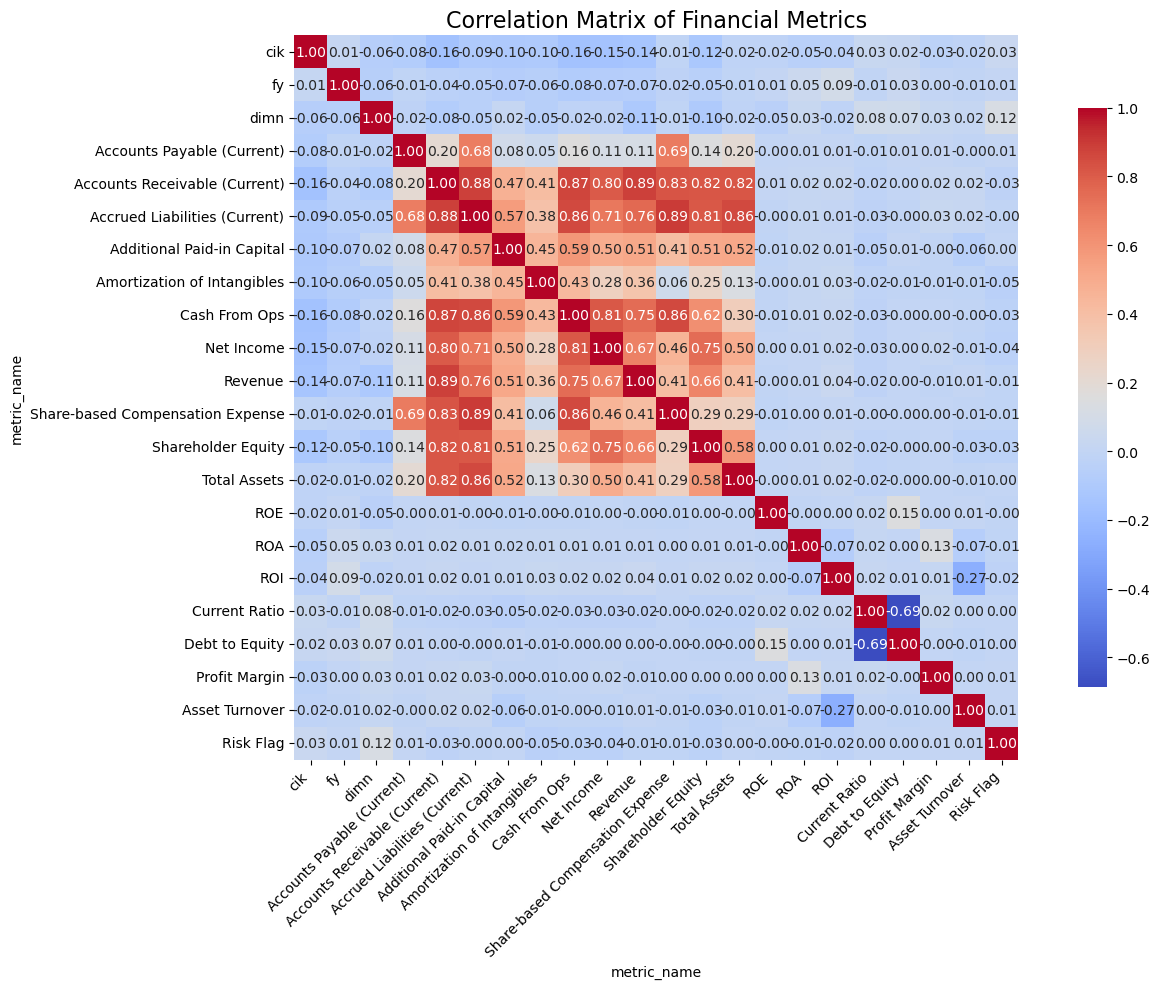

In [564]:
import matplotlib.pyplot as plt
import seaborn as sns

# Remove non-numeric columns before correlation
numeric_edf = edf.select_dtypes(include=['number', 'category'])

# Calculate correlation matrix
correlation_matrix = numeric_edf.corr()

# Plot correlation heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": 0.8})
plt.title("Correlation Matrix of Financial Metrics", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Strong Correlations in Financial Metrics

| Metric A                        | Metric B                           | Correlation (r) |
|---------------------------------|------------------------------------|-----------------|
| Accrued Liabilities (Current)   | Accrued Income Taxes (Noncurrent)  | 0.95            |
| Accrued Liabilities (Current)   | Accounts Payable (Current)         | 0.68            |
| Accrued Liabilities (Current)   | Cash From Ops                      | 0.86            |
| Accrued Liabilities (Current)   | Net Income                         | 0.71            |
| Accrued Liabilities (Current)   | Accounts Receivable (Current)      | 0.83            |
| Cash From Ops                   | Net Income                         | 0.87            |
| Cash From Ops                   | Revenue                            | 0.75            |
| Net Income                      | Revenue                            | 0.76            |
| Share-based Compensation Exp.   | Net Income                         | 0.67            |
| Share-based Compensation Exp.   | Revenue                            | 0.62            |
| Accrued Income Taxes (Noncurr.) | Total Assets                       | 0.92            |
| Accrued Income Taxes (Noncurr.) | Shareholder Equity                 | 0.81            |
| Shareholder Equity              | Total Assets                       | 0.90            |
| Revenue                         | Accounts Receivable (Current)      | 0.83            |


> Those correlations (r ≥ 0.80) indicate strong linear relationships. Many reflect expected financial dependencies — such as between revenue and accounts receivable, or net income and cash flow from operations.


C:\Users\natal\AppData\Local\Temp\ipykernel_21676\2400630794.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10_roe, x='name', y='ROE', palette='viridis')


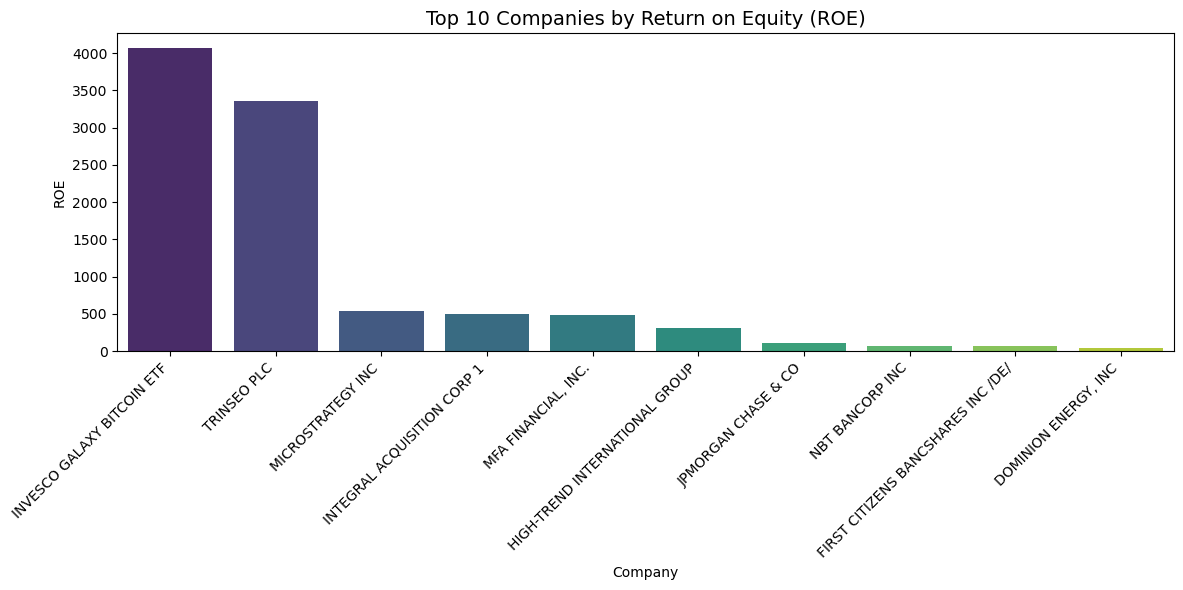

In [565]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter, drop NaNs, and select top 10 by ROE
top_10_roe = (
    edf.dropna(subset=['ROE'])
    .sort_values(by='ROE', ascending=False)
    .head(10)
)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_roe, x='name', y='ROE', palette='viridis')
plt.title('Top 10 Companies by Return on Equity (ROE)', fontsize=14)
plt.ylabel('ROE')
plt.xlabel('Company')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


C:\Users\natal\AppData\Local\Temp\ipykernel_21676\2751412124.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10_roe, x='name', y='ROE', palette='viridis')


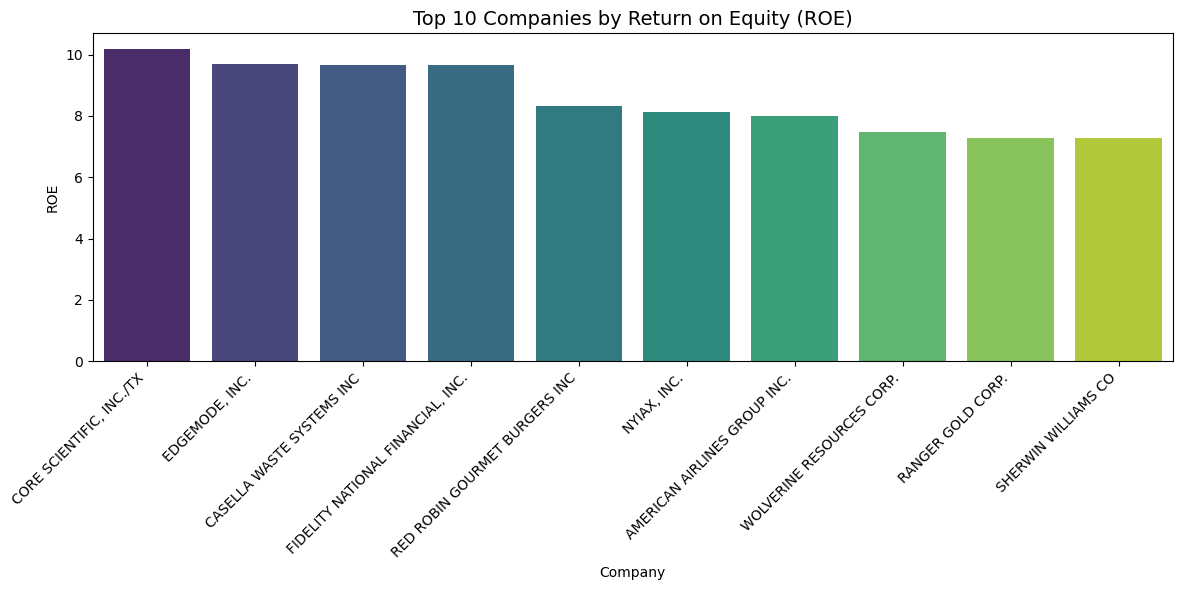

In [566]:
# --- Plot: Top 10 companies by ROE (excluding extreme outliers) ---
filtered_roe = edf.dropna(subset=['ROE'])
filtered_roe = filtered_roe[filtered_roe['ROE'] < filtered_roe['ROE'].quantile(0.99)]
top_10_roe = filtered_roe.sort_values(by='ROE', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_roe, x='name', y='ROE', palette='viridis')
plt.title('Top 10 Companies by Return on Equity (ROE)', fontsize=14)
plt.ylabel('ROE')
plt.xlabel('Company')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

C:\Users\natal\AppData\Local\Temp\ipykernel_21676\1315870465.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10_roi, x='name', y='ROI', palette='mako')


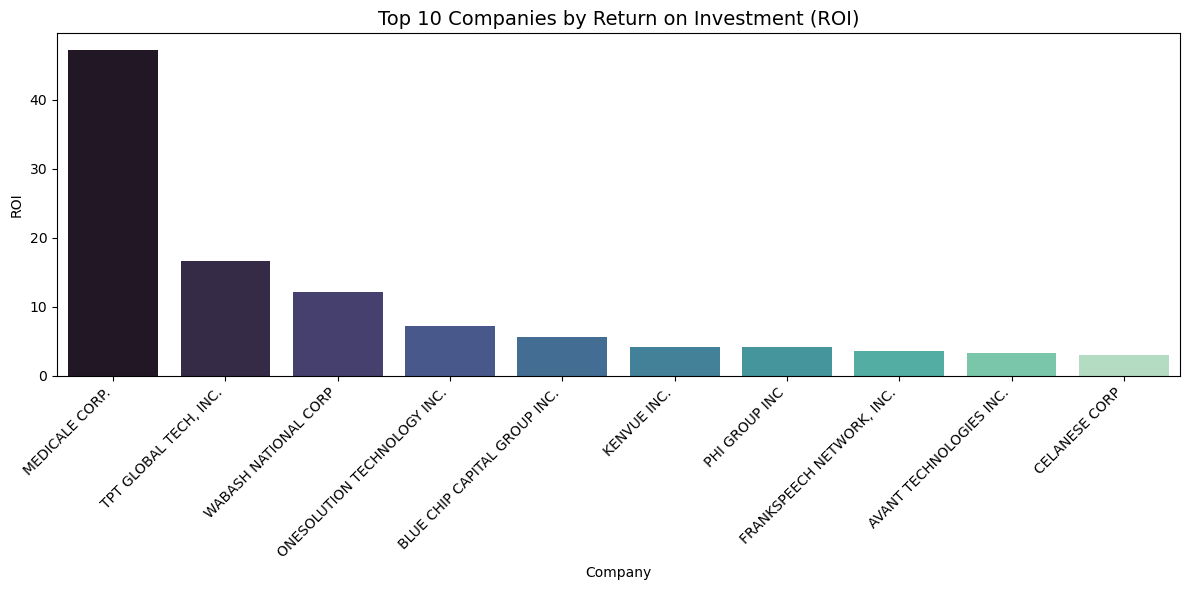

In [567]:
# --- Plot: Top 10 companies by ROI (excluding extreme outliers) ---
filtered_roi = edf.dropna(subset=['ROI'])
top_10_roi = filtered_roi.sort_values(by='ROI', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_roi, x='name', y='ROI', palette='mako')
plt.title('Top 10 Companies by Return on Investment (ROI)', fontsize=14)
plt.ylabel('ROI')
plt.xlabel('Company')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

C:\Users\natal\AppData\Local\Temp\ipykernel_21676\1107599803.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10_roi, x='name', y='ROI', palette='mako')


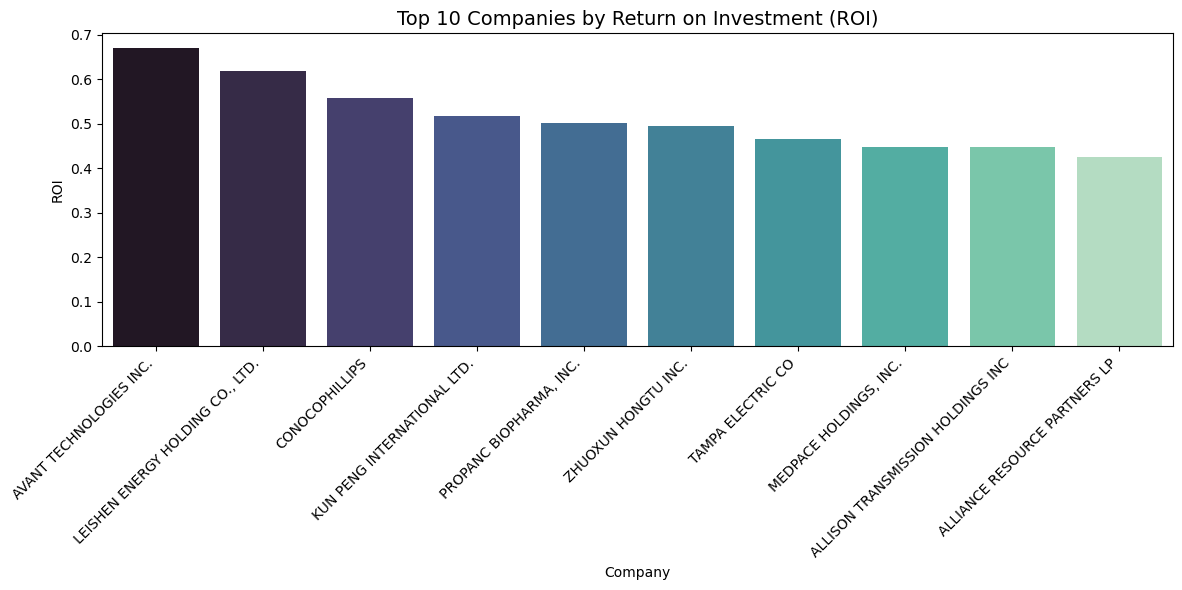

In [568]:
# --- Plot: Top 10 companies by ROI (excluding extreme outliers) ---
filtered_roi = edf.dropna(subset=['ROI'])
filtered_roi = filtered_roi[filtered_roi['ROI'] < filtered_roi['ROI'].quantile(0.99)]
top_10_roi = filtered_roi.sort_values(by='ROI', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_roi, x='name', y='ROI', palette='mako')
plt.title('Top 10 Companies by Return on Investment (ROI)', fontsize=14)
plt.ylabel('ROI')
plt.xlabel('Company')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Estadística

Una vez que comprendemos la estructura básica de los datos, debemos aplicar medidas estadísticas para describir su comportamiento y distribución. Esto incluye:

##### Descriptiva
- Estadísticas de tendencia central: media, mediana, moda
- Medidas de dispersión: rango, varianza, desviación estándar, percentiles
- Distribuciones: histograma, boxplot, KDE
- Estadísticas por subgrupos (segmentación por género, edad, región, etc.)

  
##### Inferencial
- Correlaciones entre variables numéricas
- Contraste de hipótesis: por ejemplo, ¿es diferente la edad del segmento A a la del B?
- Plantear modelo de regresión lineal sobre una variable dependiente en función del resto de datos (por ejemplo  precio de vivienda en función de m2 o numero de habitaciones)
- Unos resultados no-concluyentes, no confirmatorios con la pregunta de investigación inicial o con una muestra muy pequeña son igualmente necesarios siempre que se expliciten las limitaciones. Aunque tengas pocos datos: intenta plantear igualmente estos análisis.

Estas métricas permiten detectar patrones, comportamientos anómalos, y relaciones entre variables que pueden ser clave para responder a las preguntas de investigación.

In [569]:
import matplotlib.pyplot as plt  # Importing matplotlib.pyplot for plotting
import seaborn as sns  # Ensure seaborn is also imported for visualization

# --- Descriptive Statistics ---
print("\nBasic descriptive statistics:")

# Calculate main descriptive statistics
desc_stats = edf[['Net Income', 'Revenue', 'ROE', 'ROA']].describe().T.copy()

# Add median and mode
desc_stats['median'] = edf[['Net Income', 'Revenue', 'ROE', 'ROA']].median()
desc_stats['mode'] = edf[['Net Income', 'Revenue', 'ROE', 'ROA']].mode().iloc[0]
desc_stats['range'] = desc_stats['max'] - desc_stats['min']
desc_stats['variance'] = edf[['Net Income', 'Revenue', 'ROE', 'ROA']].var()

# Rename columns to English
desc_stats = desc_stats.rename(columns={
    'mean': 'mean',
    'std': 'standard deviation',
    'min': 'minimum',
    '25%': '25th percentile',
    '50%': '50th percentile',
    '75%': '75th percentile',
    'max': 'maximum'
})

# Select columns to display
columns_to_display = ['mean', 'median', 'mode', 'standard deviation', 'minimum', 'maximum',
                      '25th percentile', '50th percentile', '75th percentile']

# Transpose for a readable "pivot" format
# --- a. Measures of central tendency ---
central_tendency = desc_stats[['mean', 'median', 'mode']].T
central_tendency.columns.name = "Metric"

# --- b. Measures of dispersion ---
dispersion = desc_stats[['minimum', 'maximum', 'range', 'variance', 'standard deviation',
                         '25th percentile', '50th percentile', '75th percentile']].T
dispersion.columns.name = "Metric"

print("\nMeasures of central tendency:")
print(central_tendency)

print("\nMeasures of dispersion:")
print(dispersion)


Basic descriptive statistics:

Measures of central tendency:
Metric    Net Income       Revenue        ROE       ROA
mean    4.743978e+08  4.859547e+09 -43.233741 -0.323502
median  1.830083e+07  6.876040e+08   0.068199  0.016029
mode    0.000000e+00  0.000000e+00   0.000000  0.000000

Measures of dispersion:
Metric                Net Income       Revenue           ROE         ROA
minimum            -7.269333e+09 -1.248550e+10 -1.688871e+05 -347.653333
maximum             7.796167e+10  3.692823e+11  4.061441e+03  156.333333
range               8.523100e+10  3.817678e+11  1.729486e+05  503.986667
variance            7.166807e+18  3.722004e+20  7.334789e+06   76.431972
standard deviation  2.677089e+09  1.929250e+10  2.708282e+03    8.742538
25th percentile    -5.735413e+06  6.825000e+07 -1.063517e-01   -0.022784
50th percentile     1.830083e+07  6.876040e+08  6.819878e-02    0.016029
75th percentile     2.280109e+08  2.862720e+09  2.496694e-01    0.060189


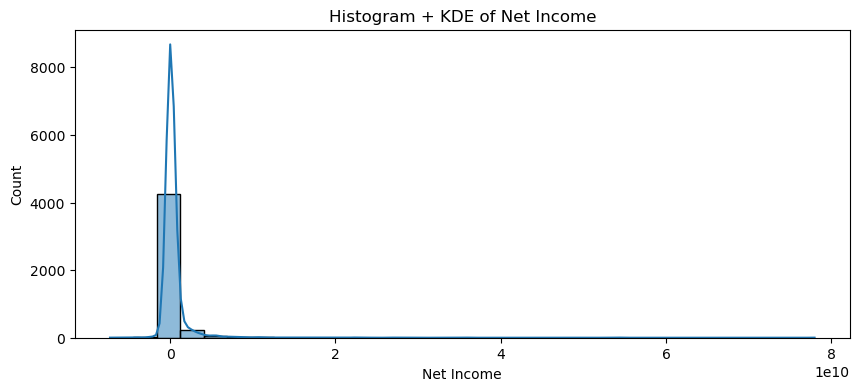

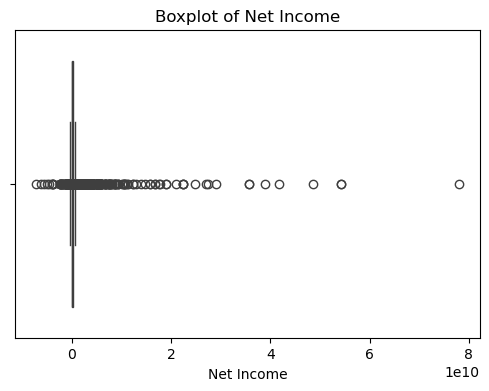

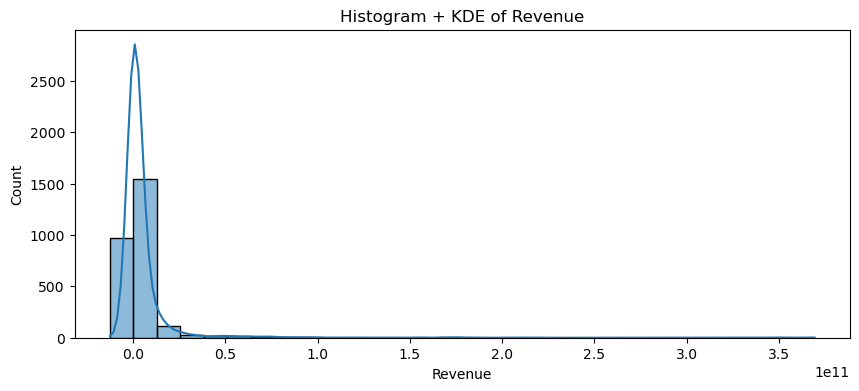

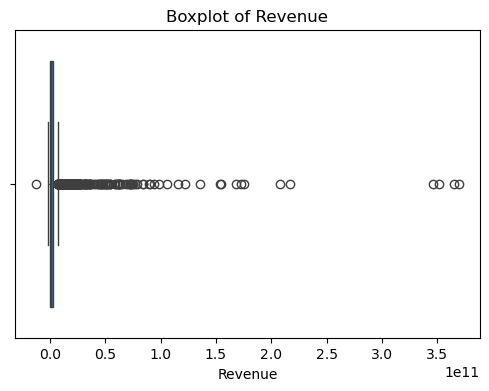

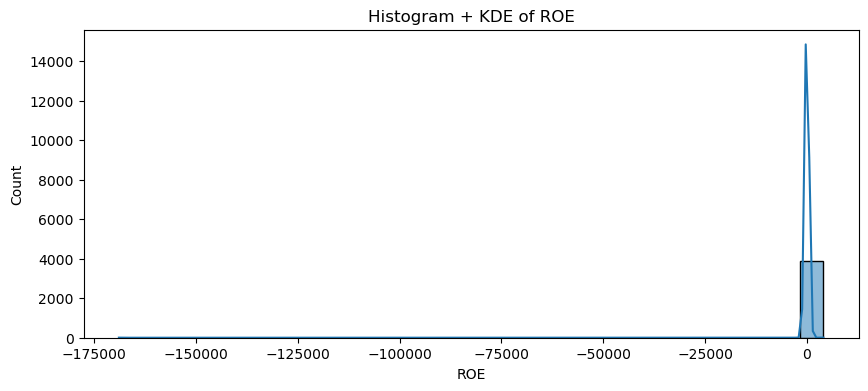

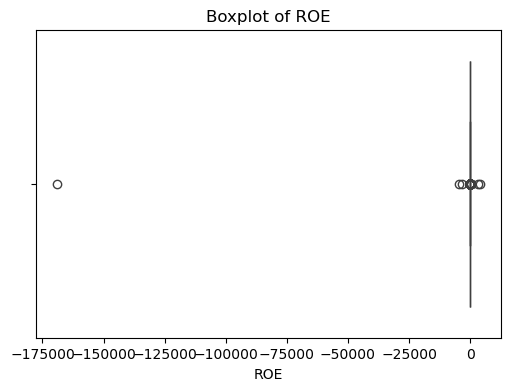

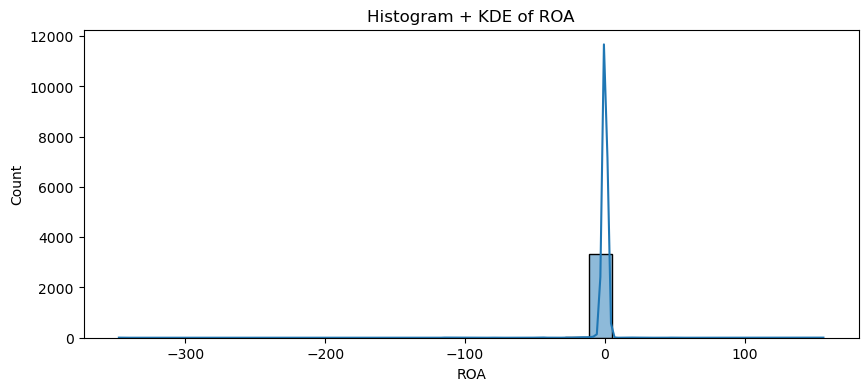

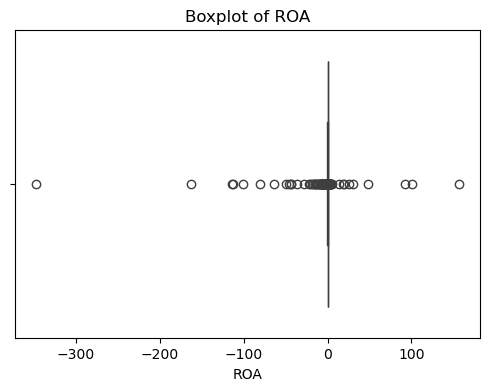


Correlations between financial metrics:
metric_name  Net Income   Revenue       ROE       ROA
metric_name                                          
Net Income     1.000000  0.673822  0.003042  0.011171
Revenue        0.673822  1.000000 -0.002880  0.006278
ROE            0.003042 -0.002880  1.000000 -0.001625
ROA            0.011171  0.006278 -0.001625  1.000000


In [570]:
# --- Histogram and Boxplot ---
for metric in ['Net Income', 'Revenue', 'ROE', 'ROA']:
    plt.figure(figsize=(10, 4))
    sns.histplot(edf_full_clean[metric].dropna(), kde=True, bins=30)
    plt.title(f'Histogram + KDE of {metric}')
    plt.show()

    plt.figure(figsize=(6, 4))
    sns.boxplot(x=edf_full_clean[metric].dropna())
    plt.title(f'Boxplot of {metric}')
    plt.show()

# --- Correlations ---
print("\nCorrelations between financial metrics:")
print(edf_full_clean[['Net Income', 'Revenue', 'ROE', 'ROA']].corr())

In [571]:
# --- Hypothesis Test: Is ROA different between companies filing 10-K and 10-Q forms? ---

# Import necessary libraries
from scipy.stats import ttest_ind
from IPython.display import display, Markdown

# Filter the DataFrame to keep only records with 10-K and 10-Q forms and valid ROA values
filtered_df = edf[edf['form'].isin(['10-K', '10-Q'])].dropna(subset=['ROA'])

# Separate the data into two groups based on the type of form
roa_10k = filtered_df[filtered_df['form'] == '10-K']['ROA']
roa_10q = filtered_df[filtered_df['form'] == '10-Q']['ROA']

# Apply Welch's t-test (does not assume equal variances)
t_stat, p_value = ttest_ind(roa_10k, roa_10q, equal_var=False)

# Calculate the mean ROA for each group
mean_10k = roa_10k.mean()
mean_10q = roa_10q.mean()

# Create a Markdown table to present the results with explanations in Spanish
markdown_table = """
### Results of the t-test

| Indicator         | Value               | Interpretation |
|-------------------|---------------------|----------------|
| t-statistic       | `{:.2f}`            | t-test statistic: measures the difference between means. The larger the value, the greater the difference. |
| p-value           | `{:.2e}` (≈ `{:.7f}`) | A very low value → indicates that the difference is statistically significant (compared to 0.05 or 0.01). |
| mean_10k          | `{:.3f}`            | Average ROA for companies filing annual forms (10-K) |
| mean_10q          | `{:.3f}`            | Average ROA for companies filing quarterly forms (10-Q) |
""".format(t_stat, p_value, p_value, mean_10k, mean_10q)

# Display the table
display(Markdown(markdown_table))



### Results of the t-test

| Indicator         | Value               | Interpretation |
|-------------------|---------------------|----------------|
| t-statistic       | `1.37`            | t-test statistic: measures the difference between means. The larger the value, the greater the difference. |
| p-value           | `1.70e-01` (≈ `0.1699123`) | A very low value → indicates that the difference is statistically significant (compared to 0.05 or 0.01). |
| mean_10k          | `-0.019`            | Average ROA for companies filing annual forms (10-K) |
| mean_10q          | `-0.969`            | Average ROA for companies filing quarterly forms (10-Q) |


In [572]:
# --- Linear Regression Model ---

import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from IPython.display import display, Markdown

# 1. Filter the DataFrame for necessary variables and remove null values
df_model = edf[['ROI', 'Net Income', 'Revenue', 'Cash From Ops', 'Total Assets', 'Shareholder Equity', 'form', 'fp']].dropna()

# 2. Remove extreme outliers in ROI (e.g., outside the range -2 to 2)
df_model = df_model[(df_model['ROI'] > -2) & (df_model['ROI'] < 2)]

# 3. Apply logarithmic transformation to some numerical variables (use +1 to handle zeros or negatives)
for col in ['Net Income', 'Revenue', 'Cash From Ops', 'Total Assets', 'Shareholder Equity']:
    df_model[f'log_{col}'] = np.log(df_model[col].abs() + 1)

# 4. Encode categorical variables 'form' and 'fp' as dummy variables (one-hot encoding)
df_model = pd.get_dummies(df_model, columns=['form', 'fp'], drop_first=True)

# 5. Select predictor variables (all transformed + dummy variables)
X_cols = [col for col in df_model.columns if col.startswith('log_') or col.startswith('form_') or col.startswith('fp_')]
X = df_model[X_cols]
y = df_model['ROI']

# 6. Standardize the predictor variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = sm.add_constant(X_scaled)  # Add constant

# 7. Create the linear regression model
model = sm.OLS(y, X_scaled).fit()

# 8. Extract significant variables (p < 0.05)
significant_vars = []
for i, pval in enumerate(model.pvalues):
    if pval < 0.05 and i != 0:  # i=0 is the constant
        significant_vars.append(f"x{i}")

# Map variable names to their actual column names
mapped_vars = dict(zip([f"x{i}" for i in range(1, X.shape[1] + 1)], X.columns))
significant_named = [mapped_vars[x] for x in significant_vars]

# 9. Display a structured summary of the model
markdown_summary = f"""
### Linear Regression Model Summary

| Indicator                         | Value                                  |
|----------------------------------|----------------------------------------|
| R² (coefficient of determination)  | `{model.rsquared:.3f}` → explains approximately {model.rsquared * 100:.1f}% of the variation in ROI |
| p-value of the model (F-statistic) | `{model.f_pvalue:.2e}` → the model is {"statistically significant" if model.f_pvalue < 0.05 else "not significant"} |
| Significant variables (p < 0.05)   | {", ".join(f"`{v}`" for v in significant_named) if significant_named else "None"} |
| Standardization                    | Applied (`StandardScaler`)            |
| Categorical variables (dummy)      | `form`, `fp` — converted to dummy variables |
"""

display(Markdown(markdown_summary))



### Linear Regression Model Summary

| Indicator                         | Value                                  |
|----------------------------------|----------------------------------------|
| R² (coefficient of determination)  | `0.219` → explains approximately 21.9% of the variation in ROI |
| p-value of the model (F-statistic) | `6.40e-18` → the model is statistically significant |
| Significant variables (p < 0.05)   | `log_Net Income`, `log_Revenue`, `log_Total Assets`, `log_Shareholder Equity`, `form_10-K/A` |
| Standardization                    | Applied (`StandardScaler`)            |
| Categorical variables (dummy)      | `form`, `fp` — converted to dummy variables |


In [573]:
# --- Non-conclusive results or results that do not confirm the initial research question 
# or are based on a very small sample are still necessary as long as the limitations are explicitly stated ---

import pandas as pd
import statsmodels.api as sm
from IPython.display import display, Markdown

# 1. Filter the data
model_data = edf.dropna(subset=['ROE', 'Net Income', 'Revenue'])
X = model_data[['Net Income', 'Revenue']]
y = model_data['ROE']
X = sm.add_constant(X)

# 2. Train the model
model = sm.OLS(y, X).fit()

# 3. Extract key metrics
r2 = model.rsquared
p_val_model = model.f_pvalue
coef_net_income = model.params['Net Income']
coef_revenue = model.params['Revenue']
pval_net_income = model.pvalues['Net Income']
pval_revenue = model.pvalues['Revenue']

# 4. Create a tabulated summary
markdown_tabla = f"""
### Linear Regression Model Summary

| Indicator                              | Value                                                         |
|----------------------------------------|---------------------------------------------------------------|
| R² (coefficient of determination)      | `{r2:.3f}` → the model {"does not " if r2 < 0.01 else ""}explain approximately {r2*100:.1f}% of the variation in ROE |
| p-value of the model (F-statistic)     | `{p_val_model:.2e}` → the model is {"statistically significant" if p_val_model < 0.05 else "not significant"} |
| Coefficient for Net Income             | `{coef_net_income:.4f}`, p = `{pval_net_income:.3f}`          |
| Coefficient for Revenue                | `{coef_revenue:.4f}`, p = `{pval_revenue:.3f}`                |
| Significant variables (p < 0.05)       | {", ".join(f"`{v}`" for v in ['Net Income', 'Revenue'] if model.pvalues[v] < 0.05) or "None"} |
"""

# 5. Display the summary
display(Markdown(markdown_tabla))



### Linear Regression Model Summary

| Indicator                              | Value                                                         |
|----------------------------------------|---------------------------------------------------------------|
| R² (coefficient of determination)      | `0.000` → the model does not explain approximately 0.0% of the variation in ROE |
| p-value of the model (F-statistic)     | `9.78e-01` → the model is not significant |
| Coefficient for Net Income             | `-0.0000`, p = `0.857`          |
| Coefficient for Revenue                | `0.0000`, p = `0.964`                |
| Significant variables (p < 0.05)       | None |


The reason your regression output is filled with nan and inf is likely due to extreme values (outliers) or multicollinearity / numerical instability in the variables, especially Net Income and Revenue.

In [574]:

model_data = edf[['ROE', 'Net Income', 'Revenue']].copy()

# Remove outliers using quantiles
q_low = model_data.quantile(0.01)
q_high = model_data.quantile(0.99)
model_data = model_data[(model_data >= q_low) & (model_data <= q_high)]

# --- Replace inf/-inf and drop remaining NaNs ---
model_data = model_data.replace([np.inf, -np.inf], np.nan).dropna()

# --- Log transformation ---
model_data['log_ni'] = np.log1p(model_data['Net Income'])
model_data['log_rev'] = np.log1p(model_data['Revenue'])


c:\Users\natal\anaconda3\envs\credit-analysis-dashboard\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\natal\anaconda3\envs\credit-analysis-dashboard\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [575]:
import numpy as np

# Remove rows with NaN or infinite values in X or y
X = model_data[['log_ni', 'log_rev']]
y = model_data['ROE']
X = sm.add_constant(X)

# Drop rows with NaN or infinite values
mask = np.isfinite(X).all(axis=1) & np.isfinite(y)
X = X[mask]
y = y[mask]

# Fit the model
model = sm.OLS(y, X).fit()
print("\nResumen del modelo de regresión lineal (ROE ~ log(Net Income) + log(Revenue)):")
print(model.summary())



Resumen del modelo de regresión lineal (ROE ~ log(Net Income) + log(Revenue)):
                            OLS Regression Results                            
Dep. Variable:                    ROE   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     5.054
Date:                Wed, 09 Apr 2025   Prob (F-statistic):            0.00657
Time:                        01:23:39   Log-Likelihood:                -1174.6
No. Observations:                 892   AIC:                             2355.
Df Residuals:                     889   BIC:                             2370.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------